# Statistical Arbitrage Cointegration

## Strategy

We find pairs of coins that are cointegrated using the augmented Engle-Granger two-step cointegration test via the `coint` function of [the `statsmodels.tsa.stattools` module](https://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.coint.html). We then employ pairs trading for the pairs we find.

## Method, Fixed Cointegrated Pairs

- Select the top cryptocurrencies from December 2020 and use historical price data from December 2020 to August 31, 2025. (We use data from December 2020 to avoid lookahead bias for our selection of cryptocurrencies in the universe.)
- Use the Engle-Granger two-step method to identify cointegrated pairs over the interval from December 2020 to December 2022.
- 


- Use the Engle-Granger two-step method to find cointegrated pairs over a trailing window of x weeks (x to be determined from experimentation) with a significance level $\alpha$ to be determined.
- Re-calculate the hedge ratio over periods of y weeks (y to be determined) and trade the spread between pairs of cointegrated coins during the training period.
- Analyze the results over the training period and select the variations of x, y, and $\alpha$ with the highest sharpe ratios (which should hopefully also have manageable maximum drawdown durations). Run those variations during the testing period.

## Data Collection

## Implementation

## Transaction Costs

## Results

TO BE FILLED IN

# Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from ipynb.fs.full.utility_functions import (
    get_price_data,
    calculate_covariance_directly,
    get_strategy_stats,
)
from datetime import datetime

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


# Price Data Collection

In [2]:
univ = [
    "BTCUSDT", "ETHUSDT", "ADAUSDT", "BNBUSDT", "XRPUSDT", "DOTUSDT", "MATICUSDT", "LTCUSDT", "BCHUSDT",
    "LINKUSDT", "XLMUSDT", "USDCUSDT", "EOSUSDT", "TRXUSDT", "XTZUSDT", "FILUSDT", "NEOUSDT", "DAIUSDT",
    "DASHUSDT", "VETUSDT", "ATOMUSDT", "AAVEUSDT", "UNIUSDT", "GRTUSDT", "THETAUSDT", "IOTAUSDT", "BUSDUSDT",
    "ZECUSDT", "YFIUSDT", "ETCUSDT", "WAVESUSDT", "COMPUSDT", "SNXUSDT", "DOGEUSDT", "MKRUSDT", "ZILUSDT",
    "SUSHIUSDT", "KSMUSDT", "OMGUSDT", "ONTUSDT", "ALGOUSDT", "EGLDUSDT", "BATUSDT", "DGBUSDT", "ZRXUSDT",
    "TUSDUSDT", "QTUMUSDT", "ICXUSDT", "AVAXUSDT", "RENUSDT", "HBARUSDT", "NEARUSDT", "LRCUSDT", "CELOUSDT",
    "KNCUSDT", "LSKUSDT", "OCEANUSDT", "QNTUSDT", "USTUSDT", "BANDUSDT", "MANAUSDT", "ENJUSDT", "ANTUSDT",
    "BNTUSDT", "ZENUSDT", "NMRUSDT", "RVNUSDT", "IOSTUSDT", "OXTUSDT", "CRVUSDT", "MATICUSDT", "HNTUSDT",
    "BALUSDT", "CHZUSDT"
]

px = get_price_data(univ, '4h', True, './class_project_input_prices.csv')
px

,BTCUSDT,ETHUSDT,ADAUSDT,BNBUSDT,XRPUSDT,DOTUSDT,MATICUSDT,LTCUSDT,BCHUSDT,LINKUSDT,...,BNTUSDT,ZENUSDT,NMRUSDT,RVNUSDT,IOSTUSDT,OXTUSDT,CRVUSDT,HNTUSDT,BALUSDT,CHZUSDT
open_time,,,,,,,,,,,,,,,,,,,,,
2020-12-20 00:00:00,23353.97,646.62,0.16284,32.9681,0.56944,NaN,NaN,117.34,313.46,NaN,...,NaN,12.056,NaN,NaN,NaN,0.2492,NaN,1.41095,NaN,NaN
2020-12-20 04:00:00,23604.24,655.23,0.16638,33.6559,0.57916,NaN,NaN,121.30,340.00,NaN,...,NaN,12.107,NaN,NaN,NaN,0.2477,NaN,1.43156,NaN,NaN
2020-12-20 08:00:00,23549.50,652.88,0.16463,34.8228,0.57948,NaN,NaN,118.09,349.70,NaN,...,NaN,12.237,NaN,NaN,NaN,0.2477,NaN,1.44273,NaN,NaN
2020-12-20 12:00:00,23880.85,653.24,0.16542,35.0120,0.57798,NaN,NaN,119.10,361.21,NaN,...,NaN,12.074,NaN,NaN,NaN,0.2533,NaN,1.47130,NaN,NaN
2020-12-20 16:00:00,23932.71,649.82,0.16502,34.7042,0.57306,NaN,NaN,116.60,357.09,NaN,...,NaN,12.008,NaN,NaN,NaN,0.2503,NaN,1.43083,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-08-30 16:00:00,108921.64,4352.10,0.81950,856.7600,2.80720,3.816,NaN,110.23,542.00,23.36,...,0.725,7.240,16.62,0.01323,0.00342,0.0535,0.7646,NaN,NaN,0.03830
2025-08-30 20:00:00,108569.75,4374.56,0.82170,862.6200,2.81940,3.773,NaN,110.77,552.90,23.47,...,0.725,7.240,15.16,0.01323,0.00342,0.0535,0.7646,NaN,NaN,0.03830
2025-08-31 00:00:00,109155.73,4486.79,0.83590,863.4900,2.85180,3.867,NaN,111.67,551.30,23.90,...,0.764,7.240,15.21,0.01353,0.00342,0.0535,0.7936,NaN,NaN,0.04045


# Collect Signal Values

In [32]:
find_coint_pairs_cutoff = datetime(2022, 1, 1, 0, 0)
train_variants_cutoff = datetime(2024, 1, 1, 0, 0)
# significance_level = 0.05

# px_find_coint_pairs = px.loc[:find_coint_pairs_cutoff].iloc[:-1]
# px_train_variants = px.loc[find_coint_pairs_cutoff:].iloc[:-1]

# pvalue_matrix, pairs = find_cointegrated_pairs(px_find_coint_pairs, significance_level)

In [38]:
def calculate_spread_strat_data(px_train, coin_1, coin_2, step, avg_z_score_window):
    strat_data = pd.DataFrame()

    spread_data = pd.Series()
    beta_data = pd.Series()

    for index in range(step):
        spread_data[px_train.index[index]] = np.nan
        beta_data[px_train.index[index]] = np.nan

    for index in range(step, len(px_train)):
        coin_1_prices = px_train.iloc[(index-step+1):(index+1)][coin_1]
        coin_2_prices = px_train.iloc[(index-step+1):(index+1)][coin_2]
        calculated_cov = calculate_covariance_directly(coin_1_prices, coin_2_prices)

        beta = calculated_cov / coin_2_prices.var()

        spread = px_train.iloc[index][coin_1] - beta * px_train.iloc[index][coin_2]
        spread_data[px_train.index[index]] = spread
        beta_data[px_train.index[index]] = beta

    strat_data["spread"] = spread_data
    strat_data["beta"] = beta_data
    
    z_score = (strat_data["spread"] - strat_data["spread"].rolling(avg_z_score_window).mean()) / strat_data["spread"].rolling(avg_z_score_window).std()
    strat_data["z-score"] = z_score
    
    return strat_data


def simulate_trades(px_train, strat_data, coin_1, coin_2, normalize_trades = False):
    money_earned = 0.0

    shifted_forward_strat_data = strat_data.shift()

    balance_record = pd.Series()

    coin_1_share_count = 0
    coin_2_share_count = 0.0
    coin_1_position_size_change = pd.Series()
    coin_2_position_size_change = pd.Series()
    absolute_capital = pd.Series()

    # coin_1 ~ coin_2 * b + a
    # long 1 coin_1, short b coin_2

    for i in range(len(shifted_forward_strat_data)):
        open_time = shifted_forward_strat_data.index[i]
        is_currently_holding = coin_1_share_count != 0
        z_score = shifted_forward_strat_data.iloc[i]["z-score"]
        beta = shifted_forward_strat_data.iloc[i]["beta"]
        coin_1_position_size_change[open_time] = 0.0
        coin_2_position_size_change[open_time] = 0.0

        #print(f"{open_time}: {'Holding' if is_currently_holding else 'Not Holding'}")
        
        should_print = False
        #if datetime(2024, 11, 9, 16, 0) <= open_time <= datetime(2024, 11, 11, 16, 0):
        #    should_print = True
        
        if np.isnan(px_train.iloc[i][coin_1]) or np.isnan(px_train.iloc[i][coin_2]):
            balance_record[open_time] = money_earned
            continue
        elif (z_score is None or np.isnan(z_score) or np.isnan(px_train.iloc[i][coin_1]) or 
            np.isnan(px_train.iloc[i][coin_2])):
            coin_1_share_count = 0
            coin_2_share_count = 0.0
        elif z_score > 1.75 and not is_currently_holding: # coin_1 currently overpriced, coin_2 underpriced
            coin_1_share_count = -1
            coin_2_share_count = beta
            
            #if normalize_trades:
            #    total_capital = abs(coin_1_share_count * px_train.iloc[i-1][coin_1]) + abs(coin_2_share_count * px_train.iloc[i-1][coin_2])
            #    coin_1_share_count = coin_1_share_count / total_capital
            #    coin_2_share_count = coin_2_s
            
            coin_1_position_size_change[open_time] -= (coin_1_share_count * px_train.iloc[i-1][coin_1])
            coin_2_position_size_change[open_time] -= (coin_2_share_count * px_train.iloc[i-1][coin_2])
            
            money_earned -= (coin_1_share_count * px_train.iloc[i-1][coin_1] + coin_2_share_count * px_train.iloc[i-1][coin_2])
        elif z_score < -1.75 and not is_currently_holding: # coin_1 currently underpriced, coin_2 overpriced
            coin_1_share_count = +1
            coin_2_share_count = -beta
            
            coin_1_position_size_change[open_time] -= (coin_1_share_count * px_train.iloc[i-1][coin_1])
            coin_2_position_size_change[open_time] -= (coin_2_share_count * px_train.iloc[i-1][coin_2])
            
            money_earned -= (coin_1_share_count * px_train.iloc[i-1][coin_1] + coin_2_share_count * px_train.iloc[i-1][coin_2])
        elif (coin_1_share_count == -1 and z_score < 0.75) or (coin_1_share_count == 1 and z_score > -0.75):
            
            coin_1_position_size_change[open_time] += (coin_1_share_count * px_train.iloc[i-1][coin_1])
            coin_2_position_size_change[open_time] += (coin_2_share_count * px_train.iloc[i-1][coin_2])
            
            money_earned += coin_1_share_count * px_train.iloc[i-1][coin_1] + coin_2_share_count * px_train.iloc[i-1][coin_2]
            coin_1_share_count = 0
            coin_2_share_count = 0.0

        # current_position is at the end of the interval corresponding to row i
        current_position = coin_1_share_count * px_train.iloc[i][coin_1] + coin_2_share_count * px_train.iloc[i][coin_2]
        balance_record[open_time] = money_earned + current_position
        
        if should_print:
            print(f"Time: {open_time}")
            print(f"{coin_1} share count: {coin_1_share_count}")
            print(f"{coin_2} share count: {coin_2_share_count}")
            print(f"{coin_1} price at period open: {px_train.iloc[i-1][coin_1]}")
            print(f"{coin_2} price at period open: {px_train.iloc[i-1][coin_2]}")
            print(f"{coin_1} price at period close: {px_train.iloc[i][coin_1]}")
            print(f"{coin_2} price at period close: {px_train.iloc[i][coin_2]}")
            print(f"current position: {current_position}")
            print(f"balance record: {balance_record[open_time]}")
            print(f"Price data open time: {px_train.index[i]}\n")
            
    coin_position_size_changes = {
        coin_1: coin_1_position_size_change,
        coin_2: coin_2_position_size_change,
    }

    return balance_record, coin_position_size_changes


def run_full_trade_simulation(
    px_df,
    significance_level,
    find_coint_pairs_cutoff,
    train_variants_cutoff,
    beta_calculation_window,
    z_score_avg_calculation_window
):
    px_find_coint_pairs = px_df.loc[:find_coint_pairs_cutoff].iloc[:-1]
    px_train_variants = px_df.loc[find_coint_pairs_cutoff:train_variants_cutoff].iloc[:-1]
    
    pvalue_matrix, pairs = find_cointegrated_pairs(px_find_coint_pairs, significance_level)

    coint_pairs_to_balance = dict()
    position_size_changes = dict()

    for index, (coin_1, coin_2, z_score) in enumerate(pairs):
        strat_data = calculate_spread_strat_data(
            px_train_variants,
            coin_1,
            coin_2,
            beta_calculation_window,
            z_score_avg_calculation_window
        )
        
        single_pair_gross_balance, single_pair_position_size_changes = simulate_trades(
            px_train_variants, strat_data, coin_1, coin_2)
        coint_pairs_to_balance[(coin_1, coin_2)] = single_pair_gross_balance
        
        for coin in (coin_1, coin_2):
            if coin in position_size_changes:
                position_size_changes[coin] = position_size_changes[coin] + single_pair_position_size_changes[coin]
            else:
                position_size_changes[coin] = single_pair_position_size_changes[coin]

        print(f"{index+1} / {len(pairs)}")

    total_gross_positions = sum(coint_pairs_to_balance.values())

    return total_gross_positions, pd.DataFrame(position_size_changes)


def run_and_process_trade_simulation(
    px_df,
    significance_level,
    find_coint_pairs_cutoff,
    train_variants_cutoff,
    beta_calculation_window,
    z_score_avg_calculation_window):
    
    total_gross_positions, position_size_changes = run_full_trade_simulation(
        px_df,
        significance_level,
        find_coint_pairs_cutoff,
        train_variants_cutoff,
        beta_calculation_window,
        z_score_avg_calculation_window
    )
    
    raw_gross_returns = total_gross_positions / total_gross_positions.shift() - 1
    gross_returns = raw_gross_returns[~(
        np.isnan(raw_gross_returns) | (raw_gross_returns == float('inf')) | (raw_gross_returns == float('-inf'))
    )]

    turnover = position_size_changes.loc[gross_returns.index].abs().sum(axis=1)
    tcost_bps = 20
    net_returns = gross_returns.subtract(turnover * tcost_bps * 1e-4, fill_value = 0)
    return net_returns

In [53]:
# beta_calculation_window = 6 * 7 * 20
# z_score_avg_calculation_window = 6 * 7
# significance_level = 0.00000001 # 1e-8
# 1e-8 --> SR = 0.593

results = dict()

for significance_level in (1e-8, 1e-7, 1e-6):
    for beta_calculation_window in (6 * 7 * 20, 6 * 7 * 10, 6 * 7 * 5):
        for z_score_avg_calculation_window in (
            beta_calculation_window // 10,
            beta_calculation_window // 5,
            beta_calculation_window // 2
        ):
            net_returns = run_and_process_trade_simulation(
                px,
                significance_level,
                find_coint_pairs_cutoff,
                train_variants_cutoff,
                beta_calculation_window,
                z_score_avg_calculation_window
            )
            
            net_returns_without_first = net_returns.iloc[1:]

            stats = get_strategy_stats(net_returns_without_first, 4, px.loc[net_returns_without_first.index])
            results[(significance_level, beta_calculation_window, z_score_avg_calculation_window)] = stats

# for significance_level in (0.01, 0.02, 0.05):
#     for beta_calculation_window in [840]:
#         for z_score_avg_calculation_window in [2520]:
#             net_returns = run_and_process_trade_simulation(
#                 px,
#                 significance_level,
#                 find_coint_pairs_cutoff,
#                 train_variants_cutoff,
#                 beta_calculation_window,
#                 z_score_avg_calculation_window
#             )

#             stats = get_strategy_stats(net_returns, 4, px.loc[net_returns.index])
#             results[(significance_level, beta_calculation_window, z_score_avg_calculation_window)] = stats

7 / 23
8 / 23
9 / 23
10 / 23
11 / 23
12 / 23
13 / 23
14 / 23
15 / 23
16 / 23
17 / 23
18 / 23
19 / 23
20 / 23
21 / 23
22 / 23
23 / 23


In [59]:
results_df = pd.DataFrame(results).T
results_df.index.rename(('sig', 'beta calc', 'z-score calc'), inplace=True)

results_df.sort_values("sharpe ratio", ascending=False)

avg returns  decorrelated avg returns  \
sig          beta calc z-score calc                                          
1.000000e-07 840       420             45.325890                 43.186696   
1.000000e-06 840       420             73.941790                 71.317830   
1.000000e-08 840       84               3.655766                  3.563239   
1.000000e-07 840       84               3.432870                  3.336234   
             420       42              23.119856                 23.665102   
1.000000e-08 420       42              97.245047                 97.571736   
1.000000e-06 210       105            510.281597                519.447750   
1.000000e-07 210       42             118.520201                117.826317   
1.000000e-06 840       84               2.353993                  2.264781   
             420       42               8.169464                  8.714643   
1.000000e-07 210       105              4.684744                  4.744398   
             420       84              57.690871                 57.630130   
1.000000e-06 420       84              11.328596                 11.037871   
1.000000e-08 210       21               4.128875                  2.800463   
1.000000e-06 210       21               4.049154                 -0.026931   
1.000000e-08 210       105              1.811993                  1.776770   
             420       210            -72.669607                -72.606801   
1.000000e-06 840       168             -3.199704                 -4.889043   
1.000000e-08 210       42             -26.134606                -26.538966   
             420       84             -41.317174                -40.881661   
1.000000e-06 210       42             -12.817437                -12.957568   
             420       210           -160.612174               -162.659061   
1.000000e-07 420       210           -167.045129               -169.223928   
             210       21            -127.451066               -143.070887   
1.000000e-08 840       420            -51.546108                -54.454459   
                       168            -14.161890                -17.549454   
1.000000e-07 840       168            -11.384125                -11.598333   

                                     volatility  sharpe ratio  \
sig          beta calc z-score calc                             
1.000000e-07 840       420            27.252862      1.663161   
1.000000e-06 840       420            66.276426      1.115657   
1.000000e-08 840       84              3.671647      0.995675   
1.000000e-07 840       84              3.842725      0.893343   
             420       42             28.323803      0.816269   
1.000000e-08 420       42            121.526298      0.800198   
1.000000e-06 210       105           690.771501      0.738713   
1.000000e-07 210       42            168.480583      0.703465   
1.000000e-06 840       84              3.996468      0.589018   
             420       42             16.137262      0.506248   
1.000000e-07 210       105            10.590564      0.442351   
             420       84            164.669689      0.350343   
1.000000e-06 420       84             34.053436      0.332671   
1.000000e-08 210       21             24.004607      0.172003   
1.000000e-06 210       21             33.940957      0.119300   
1.000000e-08 210       105            37.969851      0.047722   
             420       210           271.931053     -0.267235   
1.000000e-06 840       168             9.466561     -0.338001   
1.000000e-08 210       42             46.591415     -0.560932   
             420       84             70.666377     -0.584679   
1.000000e-06 210       42             21.703167     -0.590579   
             420       210           250.757212     -0.640509   
1.000000e-07 420       210           249.753214     -0.668841   
             210       21            183.524674     -0.694463   
1.000000e-08 840       420            74.147156     -0.695187   
                   

In [81]:
significance_level = 1e-7
beta_calculation_window = 840
z_score_avg_calculation_window = 420

px_find_coint_pairs = px.loc[:find_coint_pairs_cutoff].iloc[:-1]
px_full_signal_period = px.loc[find_coint_pairs_cutoff:]

#########################################

pvalue_matrix, pairs = find_cointegrated_pairs(px_find_coint_pairs, significance_level)

coint_pairs_to_balance = dict()
position_size_changes = dict()

for index, (coin_1, coin_2, z_score) in enumerate(pairs):
    strat_data = calculate_spread_strat_data(
        px_full_signal_period,
        coin_1,
        coin_2,
        beta_calculation_window,
        z_score_avg_calculation_window
    )

    single_pair_gross_balance, single_pair_position_size_changes = simulate_trades(
        px.loc[train_variants_cutoff:], strat_data.loc[train_variants_cutoff:], coin_1, coin_2)
    coint_pairs_to_balance[(coin_1, coin_2)] = single_pair_gross_balance

    for coin in (coin_1, coin_2):
        if coin in position_size_changes:
            position_size_changes[coin] = position_size_changes[coin] + single_pair_position_size_changes[coin]
        else:
            position_size_changes[coin] = single_pair_position_size_changes[coin]

    print(f"{index+1} / {len(pairs)}")

total_gross_positions = sum(coint_pairs_to_balance.values())
position_size_changes_df = pd.DataFrame(position_size_changes)

raw_gross_returns = total_gross_positions / total_gross_positions.shift() - 1
gross_returns = raw_gross_returns[~(
    np.isnan(raw_gross_returns) | (raw_gross_returns == float('inf')) | (raw_gross_returns == float('-inf'))
)]

turnover = position_size_changes_df.loc[gross_returns.index].abs().sum(axis=1)
tcost_bps = 20
net_returns = gross_returns.subtract(turnover * tcost_bps * 1e-4, fill_value = 0)

1 / 18
2 / 18
3 / 18
4 / 18
5 / 18
6 / 18
7 / 18
8 / 18
9 / 18
10 / 18
11 / 18
12 / 18
13 / 18
14 / 18
15 / 18
16 / 18
17 / 18
18 / 18


In [100]:
# net_returns.iloc[2:].apply(lambda x: max(min(x, 0.05), -0.05)).plot()
net_returns.iloc[12:].mean() / net_returns.iloc[12:].std() * np.sqrt(365 * 6)

0.7011788092959294

In [113]:
results_big_significance_large_beta_window = pd.DataFrame(results).T
results_big_significance_large_beta_window.to_csv('net_returns_big_significance_large_beta_window.csv')
results_big_significance_large_beta_window

,,,avg returns,decorrelated avg returns,volatility,sharpe ratio,decorrelated sharpe ratio,max drawdown,max drawdown duration,alpha_BTC,beta_BTC
0.01,840,2520,0.203327,2.845090,4.457290,0.045617,0.975492,-11.806431,169.833333,0.001319,0.072443
0.02,840,2520,-5.726552,-3.115277,6.344394,-0.902616,-0.579430,-11.806431,169.833333,-0.001403,0.152793
0.05,840,2520,-91.538920,-88.968852,73.708502,-1.241904,-1.208104,-50.361359,169.833333,-0.040617,0.199514


In [110]:
results_medium_significance_large_beta_window = pd.DataFrame(results).T
results_medium_significance_large_beta_window.to_csv('net_returns_medium_significance_large_beta_window.csv')
results_medium_significance_large_beta_window

,,,avg returns,decorrelated avg returns,volatility,sharpe ratio,decorrelated sharpe ratio,max drawdown,max drawdown duration,alpha_BTC,beta_BTC
0.00001,840,2520,2.096281,4.732648,4.296132,0.487946,1.777381,-11.806431,79.833333,0.002181,0.089005
0.00010,840,2520,2.072414,4.708927,4.296243,0.482378,1.768343,-11.806431,79.833333,0.002170,0.088581
0.00100,840,2520,2.072414,4.708927,4.296243,0.482378,1.768343,-11.806431,79.833333,0.002170,0.088581


In [104]:
results_small_significance_large_beta_window = pd.from_csv('./net_returns_small_significance_large_beta_window.csv')
results_small_significance_large_beta_window.sort_values("sharpe ratio", ascending=False)

,,,avg returns,decorrelated avg returns,volatility,sharpe ratio,decorrelated sharpe ratio,max drawdown,max drawdown duration,alpha_BTC,beta_BTC
1.000000e-08,840,2520,2.150116,4.786617,4.296591,0.500424,1.797164,-11.806431,51.166667,0.002206,0.088674
1.000000e-07,840,2520,2.132174,4.768633,4.296429,0.496267,1.790583,-11.806431,57.000000,0.002198,0.088779
1.000000e-06,840,2520,2.096281,4.732648,4.296132,0.487946,1.777381,-11.806431,79.833333,0.002181,0.089005
1.000000e-08,840,1680,1.934044,4.570431,4.300409,0.449735,1.711976,-11.806431,43.166667,0.002107,0.088819
1.000000e-07,840,1680,1.878535,4.514887,4.300849,0.436782,1.690705,-11.806431,51.166667,0.002082,0.088874
1.000000e-08,420,1260,1.877163,4.512614,4.304807,0.436062,1.685845,-2.085999,35.166667,0.002081,0.091387
1.000000e-07,420,1260,1.820563,4.455883,4.305219,0.422873,1.664224,-2.085999,35.166667,0.002055,0.091707
1.000000e-08,210,630,1.801112,4.436068,4.303350,0.418537,1.658686,-15.625519,81.500000,0.002046,0.092708
1.000000e-06,840,1680,1.759913,4.396192,4.301571,0.409133,1.645509,-11.806431,65.166667,0.002028,0.088982
1.000000e-08,420,840,1.747410,4.382912,4.304293,0.405969,1.637859,-8.564186,30.500000,0.002021,0.091140


In [105]:
results_small_significance_large_beta_window.to_csv('./net_returns_small_significance_large_beta_window.csv')

In [102]:
small_significance_df = pd.DataFrame(results).T.sort_values("sharpe ratio", ascending=False)
small_significance_df.to_csv('./net_returns_small_significance_large_beta_window.csv')

small_significance_df

avg returns  decorrelated avg returns  volatility  \
1.000000e-08 420 210     0.100596                  2.738149    4.302638   
             840 420     0.030783                  2.663732    4.301610   
1.000000e-07 420 210    -0.217344                  2.419987    4.303414   
             840 420    -0.293062                  2.339055    4.302492   
1.000000e-08 210 105    -0.690379                  1.943698    4.303293   
1.000000e-06 420 210    -0.952104                  1.684955    4.305518   
             840 420    -1.040966                  1.590204    4.305153   
1.000000e-07 210 105    -1.105343                  1.529018    4.304219   
1.000000e-08 840 168    -1.271221                  1.366271    4.304845   
             420 84     -1.633856                  1.003705    4.300783   
1.000000e-07 840 168    -1.715461                  0.921952    4.306268   
1.000000e-06 210 105    -1.988777                  0.645093    4.307056   
1.000000e-07 420 84     -2.164263                  0.473171    4.301902   
1.000000e-08 840 84     -2.580438                  0.052126    4.304029   
1.000000e-06 840 168    -2.809758                 -0.172776    4.310355   
1.000000e-07 840 84     -3.190195                 -0.557807    4.305795   
1.000000e-08 210 42     -3.281793                 -0.642023    4.304065   
             420 42     -3.289659                 -0.652945    4.304563   
1.000000e-06 420 84     -3.384830                 -0.748361    4.304958   
1.000000e-07 210 42     -3.994152                 -1.354672    4.305257   
             420 42     -4.032395                 -1.396267    4.306388   
1.000000e-06 840 84     -4.615859                 -1.985461    4.310495   
             210 42     -5.653718                 -3.011959    4.311317   
             420 42     -5.680586                 -3.044456    4.312970   
1.000000e-08 210 21     -5.762512                 -3.119275    4.314362   
1.000000e-07 210 21     -6.813030                 -4.167844    4.319245   
1.000000e-06 210 21     -9.106505                 -6.458889    4.329899   

                      sharpe ratio  decorrelated sharpe ratio  max drawdown  \
1.000000e-08 420 210      0.023380                   1.023935    -19.396911   
             840 420      0.007156                   0.996750     -5.620324   
1.000000e-07 420 210     -0.050505                   0.904487     -2.923054   
             840 420     -0.068114                   0.874751   -269.692236   
1.000000e-08 210 105     -0.160430                   0.726484      0.000000   
1.000000e-06 420 210     -0.221136                   0.628890      0.000000   
             840 420     -0.241795                   0.593677    -12.203563   
1.000000e-07 210 105     -0.256805                   0.571131      0.000000   
1.000000e-08 840 168     -0.295300                   0.510121      0.000000   
             420 84      -0.379897                   0.375930      0.000000   
1.000000e-07 840 168     -0.398364                   0.343907      0.000000   
1.000000e-06 210 105     -0.461749                   0.240515      0.000000   
1.000000e-07 420 84      -0.503094                   0.177087      0.000000   
1.000000e-08 840 84      -0.599540                   0.019468      0.000000   
1.000000e-06 840 168     -0.651862                  -0.064280      0.000000   
1.000000e-07 840 84      -0.740907                  -0.208089      0.000000   
1.000000e-08 210 42      -0.762487                  -0.240277      0.000000   
             420 42      -0.764226                  -0.244298      0.000000   
1.000000e-06 420 84      -0.786263                  -0.279507      0.000000   
1.000000e-07 210 42      -0.927738                  -0.506560      0.000000   
             420 42      -0.936375                  -0.521773      0.000000   
1.000000e-06 840 84      -1.070842                  -0.738426      0.000000   
             210 42      -1.311367                  -1.123544      0.000000   
             420 42      

In [51]:
results_big_significance_large_beta_window = pd.read_csv('net_returns_big_significance_large_beta_window.csv', index_col=[0, 1, 2])
results_medium_significance_large_beta_window = pd.read_csv('net_returns_medium_significance_large_beta_window.csv', index_col=[0, 1, 2])
results_small_significance = pd.read_csv('net_returns_small_significance.csv', index_col=[0, 1, 2])
results_small_significance_large_beta_window = pd.read_csv('net_returns_small_significance_large_beta_window.csv', index_col=[0,1,2])

all_results = pd.concat([
    results_big_significance_large_beta_window,
    results_medium_significance_large_beta_window,
    results_small_significance,
    results_small_significance_large_beta_window
])

all_results.index.rename(('sig', 'beta calc', 'z-score calc'), inplace=True)
all_results.sort_values('sharpe ratio', ascending = False)

,,,avg returns,decorrelated avg returns,volatility,sharpe ratio,decorrelated sharpe ratio,max drawdown,max drawdown duration,alpha_BTC,beta_BTC
sig,beta calc,z-score calc,,,,,,,,,
1.000000e-08,840,2520,2.150116,4.786617,4.296591,0.500424,1.797164,-11.806431,51.166667,0.002206,0.088674
1.000000e-07,840,2520,2.132174,4.768633,4.296429,0.496267,1.790583,-11.806431,57.000000,0.002198,0.088779
1.000000e-05,840,2520,2.096281,4.732648,4.296132,0.487946,1.777381,-11.806431,79.833333,0.002181,0.089005
1.000000e-06,840,2520,2.096281,4.732648,4.296132,0.487946,1.777381,-11.806431,79.833333,0.002181,0.089005
1.000000e-04,840,2520,2.072414,4.708927,4.296243,0.482378,1.768343,-11.806431,79.833333,0.002170,0.088581
1.000000e-03,840,2520,2.072414,4.708927,4.296243,0.482378,1.768343,-11.806431,79.833333,0.002170,0.088581
1.000000e-08,840,1680,1.934044,4.570431,4.300409,0.449735,1.711976,-11.806431,43.166667,0.002107,0.088819
1.000000e-07,840,1680,1.878535,4.514887,4.300849,0.436782,1.690705,-11.806431,51.166667,0.002082,0.088874
1.000000e-08,420,1260,1.877163,4.512614,4.304807,0.436062,1.685845,-2.085999,35.166667,0.002081,0.091387


In [60]:
significance_level = 1e-7
beta_calculation_window = 840
z_score_avg_calculation_window = 420

net_returns = run_and_process_trade_simulation(
    px,
    significance_level,
    find_coint_pairs_cutoff,
    train_variants_cutoff,
    beta_calculation_window,
    z_score_avg_calculation_window
)

net_returns

1 / 18
2 / 18
3 / 18
4 / 18
5 / 18
6 / 18
7 / 18
8 / 18
9 / 18
10 / 18
11 / 18
12 / 18
13 / 18
14 / 18
15 / 18
16 / 18
17 / 18
18 / 18


2022-07-30 04:00:00    1.838816
2022-07-30 08:00:00    3.208867
2022-07-30 12:00:00   -0.645591
2022-07-30 16:00:00   -0.422884
2022-07-30 20:00:00    2.940458
                         ...   
2023-12-31 04:00:00    0.000205
2023-12-31 08:00:00   -0.000082
2023-12-31 12:00:00   -0.000163
2023-12-31 16:00:00    0.045675
2023-12-31 20:00:00    0.288247
Length: 3118, dtype: float64

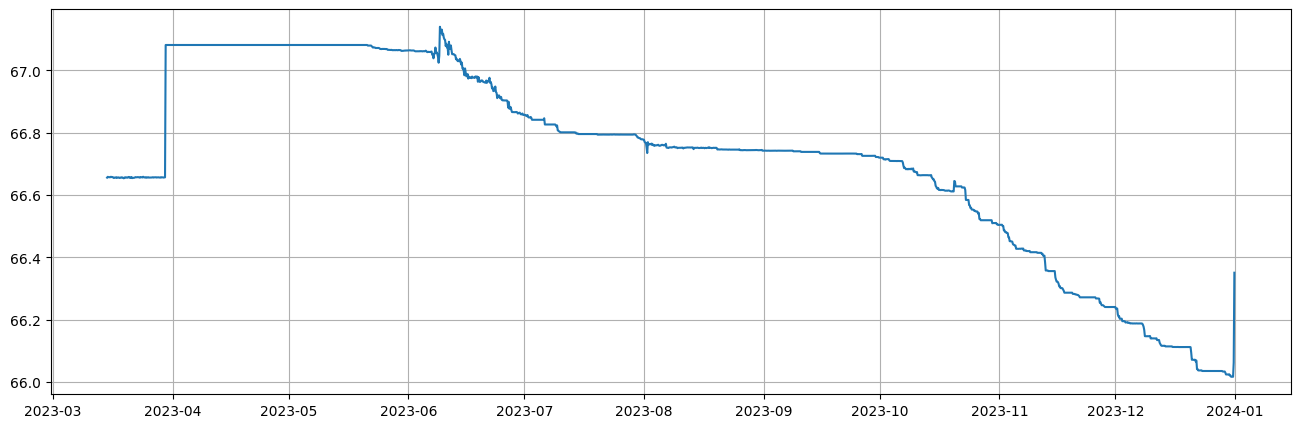

In [76]:
plt.figure(figsize=(16,5))
# plt.plot(net_returns.apply(lambda x: max(min(x, 0.1), -0.1)))
plt.plot(net_returns.cumsum().loc[datetime(2023, 3, 15, 0, 0):])

plt.grid()
plt.show()

In [48]:
net_returns.iloc[1:].mean() / net_returns.iloc[1:].std() * np.sqrt(365 * 6)

2.24620209293399

In [45]:
stats = get_strategy_stats(net_returns, 4, px.loc[net_returns.index])
stats

{'avg returns': -19.723090781302858,
 'decorrelated avg returns': 13.33355481861249,
 'volatility': 21.73796132598558,
 'sharpe ratio': -0.9073109702208301,
 'decorrelated sharpe ratio': 2.343667599501486,
 'max drawdown': 0.0,
 'max drawdown duration': 59.666666666666664,
 'alpha_BTC': 0.006151622167266418,
 'beta_BTC': -0.5979197611130997}

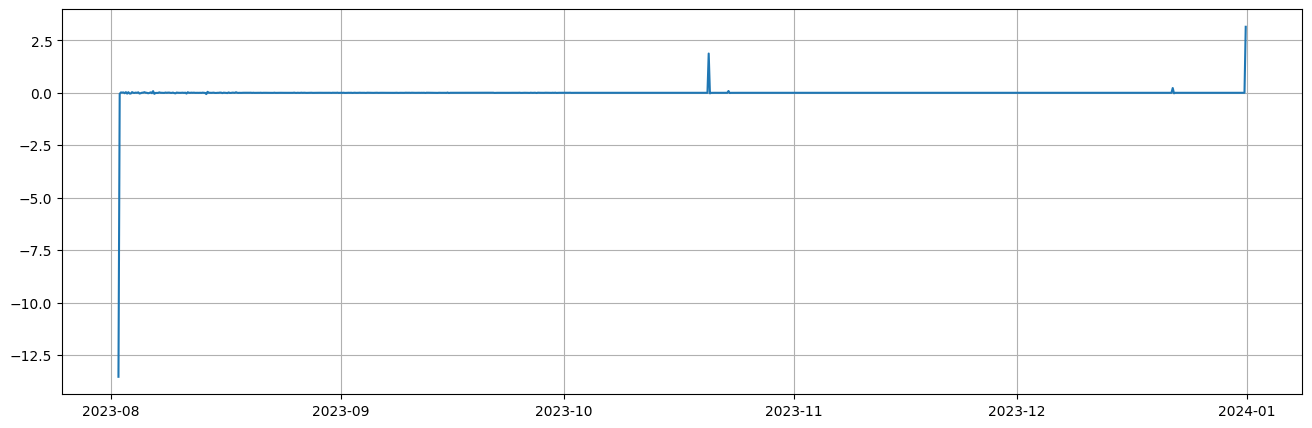

In [43]:
plt.figure(figsize=(16,5))
plt.plot(net_returns)

plt.grid()
plt.show()

In [84]:
pd.Series(get_strategy_stats(net_returns, 4, px.loc[net_returns.index]))

avg returns                   -4.315125
decorrelated avg returns      -1.674140
volatility                     4.311944
sharpe ratio                  -1.000738
decorrelated sharpe ratio     -0.624418
max drawdown                   0.000000
max drawdown duration        540.833333
alpha_BTC                     -0.000738
beta_BTC                       0.088328
dtype: float64

In [76]:
raw_gross_returns = training_balance_record / training_balance_record.shift() - 1
gross_returns = raw_gross_returns[~(
    np.isnan(raw_gross_returns) | (raw_gross_returns == float('inf')) | (raw_gross_returns == float('-inf'))
)]

turnover = position_size_changes.loc[gross_returns.index].abs().sum(axis=1)
tcost_bps = 20
net_returns = gross_returns.subtract(turnover * tcost_bps * 1e-4, fill_value = 0)
net_returns

2022-05-28 04:00:00   -4.267563
2022-05-28 08:00:00   -0.094254
2022-05-28 12:00:00    0.036007
2022-05-28 16:00:00   -0.070640
2022-05-28 20:00:00    0.076009
                         ...   
2023-12-31 04:00:00    0.000000
2023-12-31 08:00:00    0.000000
2023-12-31 12:00:00    0.000000
2023-12-31 16:00:00    0.000000
2023-12-31 20:00:00    0.300720
Length: 3496, dtype: float64

<Axes: >

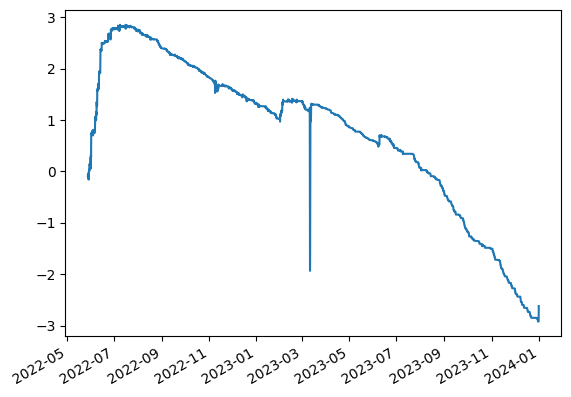

In [77]:
net_returns[1:].cumsum().plot()

In [78]:
net_returns[1:].mean() * np.sqrt(365 * 6) / net_returns[1:].std()

-0.6124474926849844

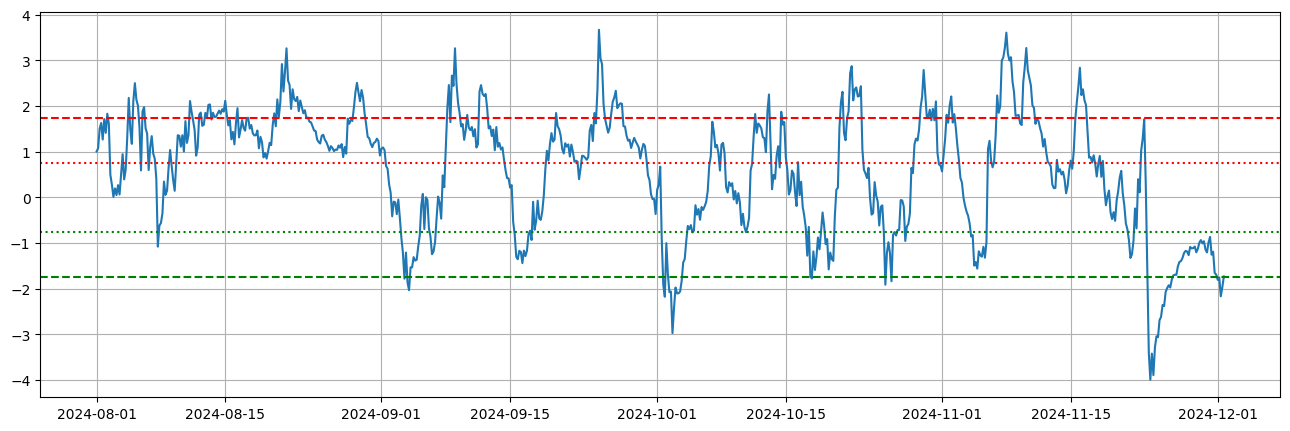

In [57]:
plt.figure(figsize=(16,5))
plt.plot(strat_data["z-score"].loc[datetime(2024, 8, 1, 0, 0):datetime(2024, 12, 1, 16, 0)])
# plt.plot(strat_data["z-score"])

plt.axhline(-1.75, color="green", linestyle="--", label="-1.75")
plt.axhline(1.75, color="red", linestyle="--", label="+1.75")
plt.axhline(-0.75, color="green", linestyle="dotted", label="-0.75")
plt.axhline(0.75, color="red", linestyle="dotted", label="+0.75")

plt.grid()
plt.show()

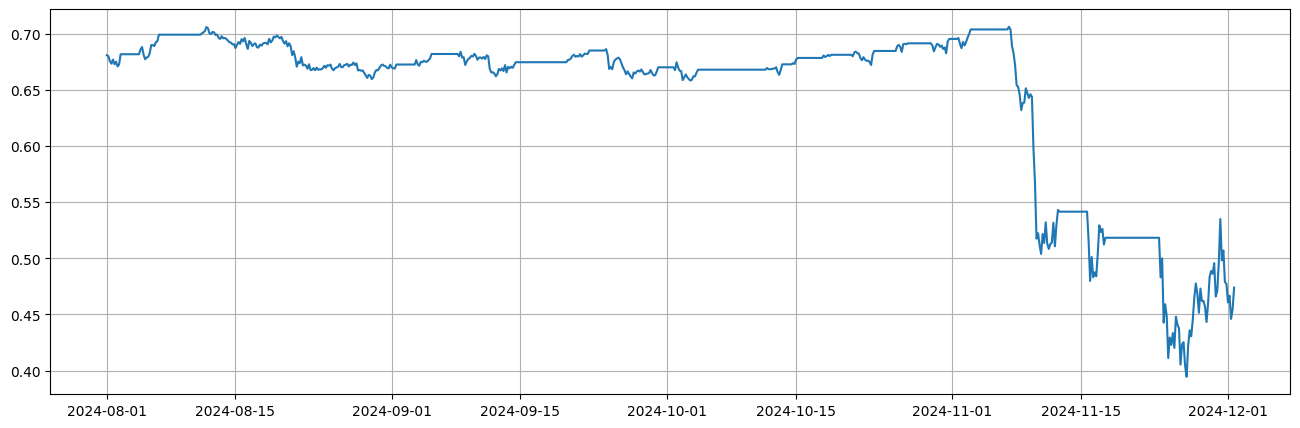

In [58]:
plt.figure(figsize=(16,5))
plt.plot(total_balance_record.loc[datetime(2024, 8, 1, 0, 0):datetime(2024, 12, 1, 16, 0)])
# plt.plot(total_balance_record)

plt.grid()
plt.show()

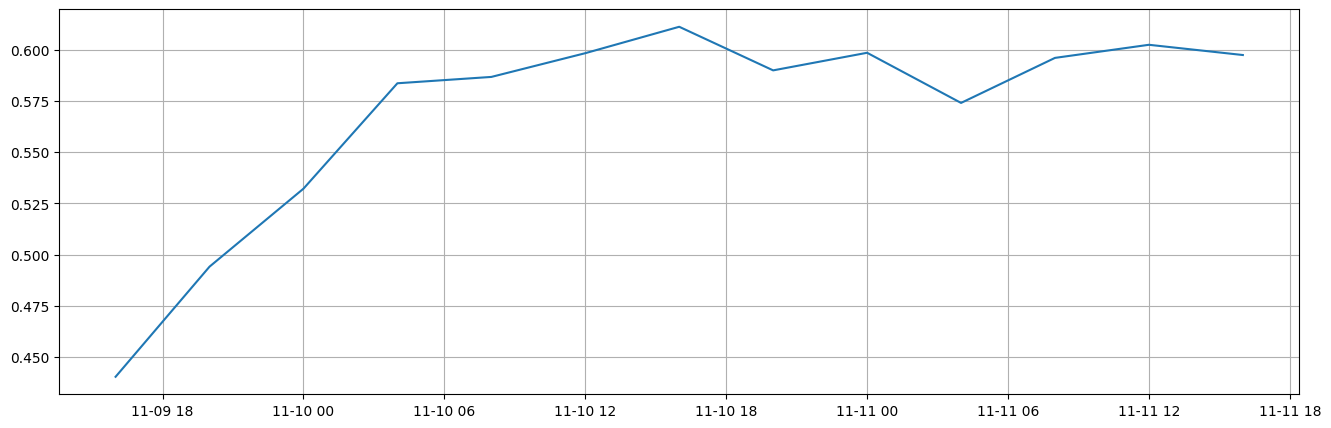

In [39]:
plt.figure(figsize=(16,5))
plt.plot(px.loc[datetime(2024, 11, 9, 16, 0):datetime(2024, 11, 11, 16, 0), "ADAUSDT"])

plt.grid()
plt.show()

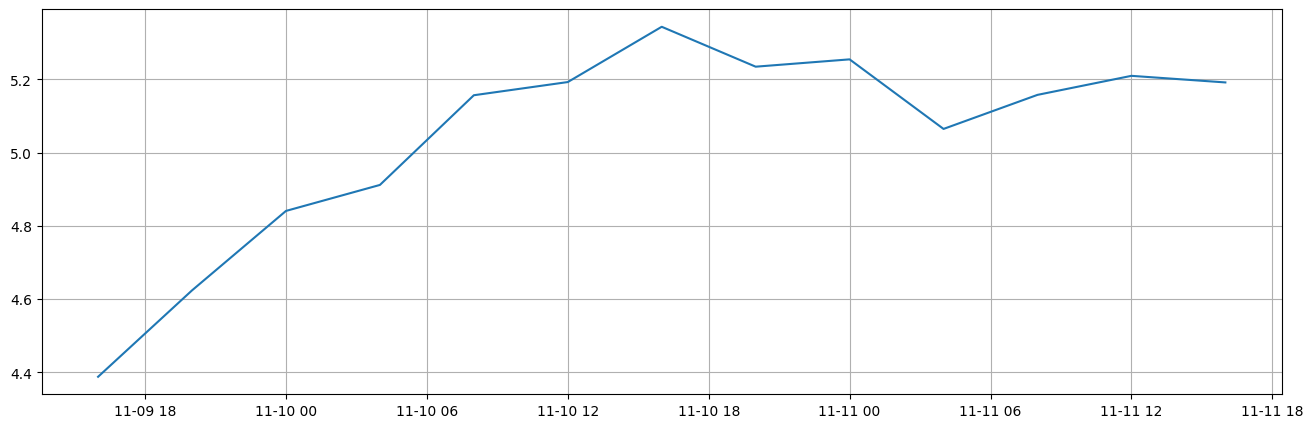

In [40]:
plt.figure(figsize=(16,5))
plt.plot(px.loc[datetime(2024, 11, 9, 16, 0):datetime(2024, 11, 11, 16, 0), "DOTUSDT"])

plt.grid()
plt.show()

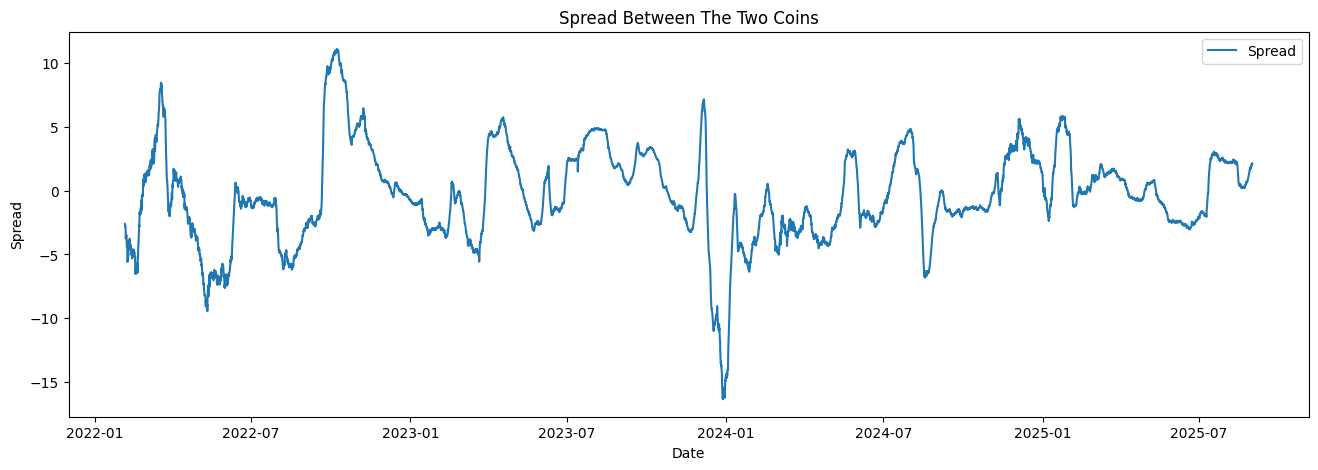

In [21]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 5))

plt.plot(strat_data["spread"], label='Spread')
# plt.axhline(pair_data.mean(), label="Spread Mean", color="black")
plt.title('Spread Between The Two Coins')
plt.xlabel('Date')
plt.ylabel('Spread')

plt.legend()
plt.show()

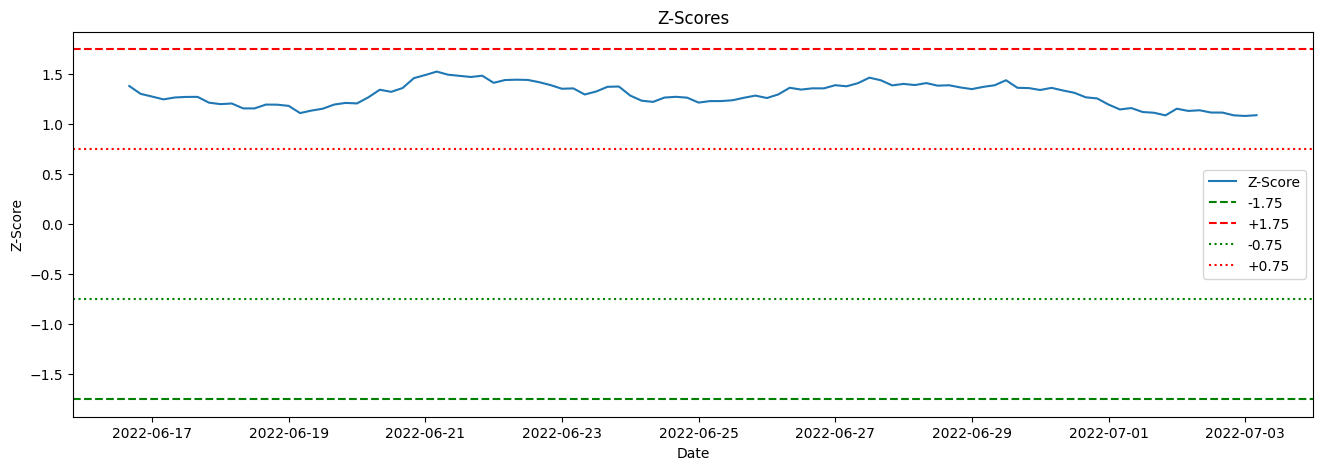

In [22]:
plt.figure(figsize=(16, 5))

plt.plot(strat_data["z-score"].iloc[1000:1100], label='Z-Score')
# plt.axhline(pair_data.mean(), label="Spread Mean", color="black")
plt.title('Z-Scores')
plt.xlabel('Date')
plt.ylabel('Z-Score')
plt.axhline(-1.75, color="green", linestyle="--", label="-1.75")
plt.axhline(1.75, color="red", linestyle="--", label="+1.75")
plt.axhline(-0.75, color="green", linestyle="dotted", label="-0.75")
plt.axhline(0.75, color="red", linestyle="dotted", label="+0.75")

plt.legend()
plt.show()

In [23]:
strat_data

,spread,beta,z-score
2022-01-01 00:00:00,NaN,NaN,NaN
2022-01-01 04:00:00,NaN,NaN,NaN
2022-01-01 08:00:00,NaN,NaN,NaN
2022-01-01 12:00:00,NaN,NaN,NaN
2022-01-01 16:00:00,NaN,NaN,NaN
...,...,...,...
2025-08-30 16:00:00,2.010829,5.015757,0.660897
2025-08-30 20:00:00,1.991351,4.946276,0.647094
2025-08-31 00:00:00,2.103023,4.848754,0.702139
2025-08-31 04:00:00,2.118362,4.748295,0.706636


In [24]:
balance_record = simulate_trades(px_train_variants, strat_data, "DOTUSDT", "XLMUSDT")

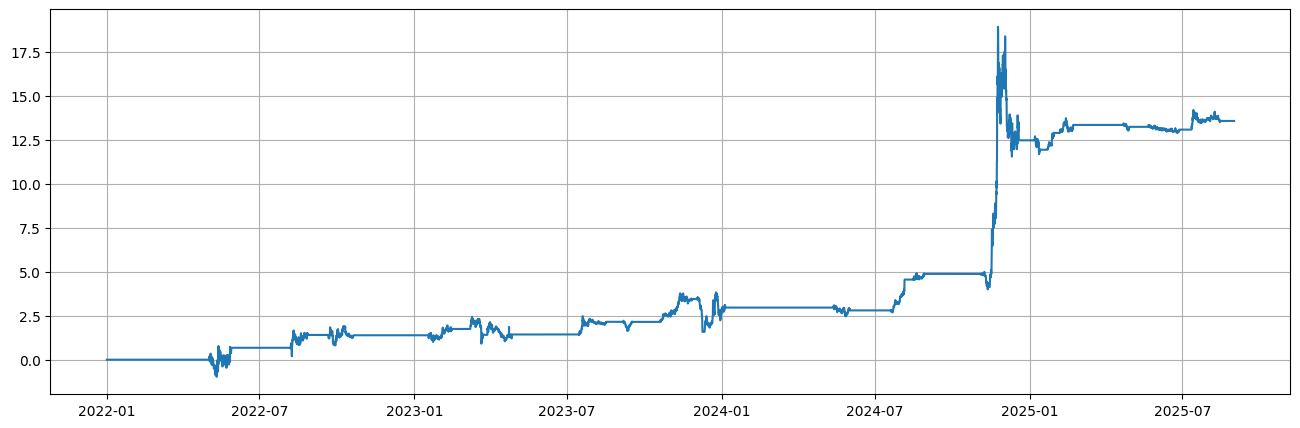

In [25]:
plt.figure(figsize=(16,5))
plt.plot(balance_record)

plt.grid()
plt.show()

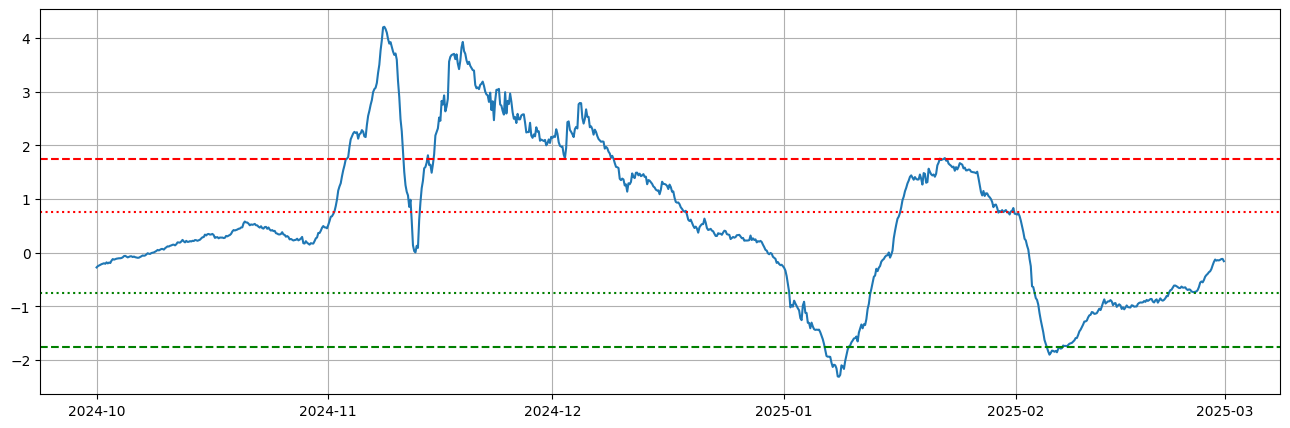

In [26]:
plt.figure(figsize=(16,5))
plt.plot(strat_data["z-score"].shift().loc[datetime(2024, 10, 1, 0, 0):datetime(2025, 2, 28, 20, 0)])

plt.axhline(-1.75, color="green", linestyle="--", label="-1.75")
plt.axhline(1.75, color="red", linestyle="--", label="+1.75")
plt.axhline(-0.75, color="green", linestyle="dotted", label="-0.75")
plt.axhline(0.75, color="red", linestyle="dotted", label="+0.75")

plt.grid()
plt.show()

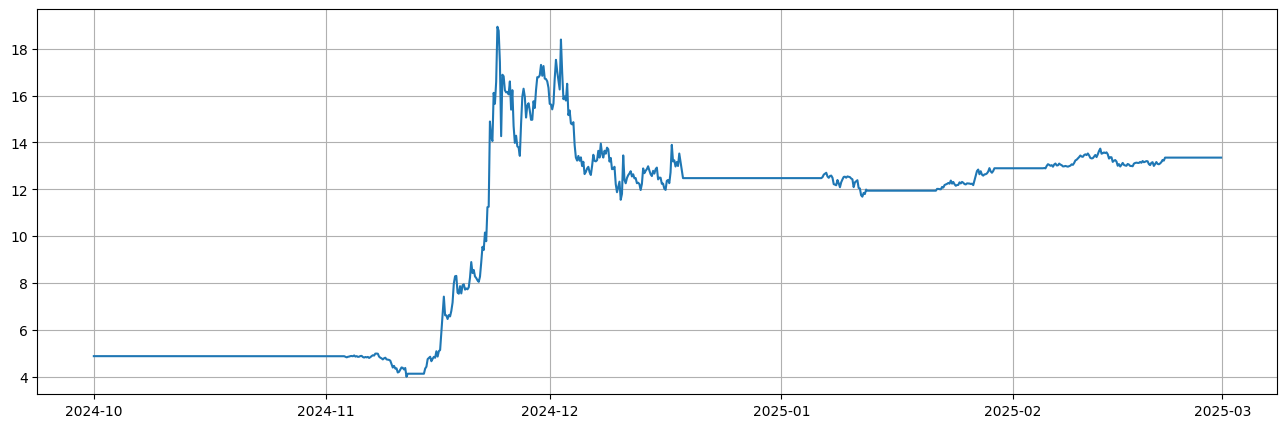

In [27]:
from datetime import datetime

plt.figure(figsize=(16,5))
plt.plot(balance_record.loc[datetime(2024, 10, 1, 0, 0):datetime(2025, 2, 28, 20, 0)])

plt.grid()
plt.show()

In [131]:
strat_data["z-score"].loc[datetime(2023, 1, 1, 0, 0)]

0.4533111731494062